In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from strategy_ml import df_options_data
from strategy_ml import spot_with_signals
class Backtest:
    def __init__(self, spot_data, options_data, starting_capital=200000, sl_pct=0.015, tp_pct=0.03, force_exit_time='15:15',lot_size =75):

        self.spot_df = spot_data
        self.options_df = options_data
        self.capital = starting_capital
        self.initial_capital = starting_capital
        self.sl_pct = sl_pct
        self.tp_pct = tp_pct
        self.force_exit_time = pd.to_datetime(force_exit_time).time()
        self.trade_log = []
        self.position = None
        self.lot_size = lot_size
        self.equity_curve = []
        self._prepare_data()

    def _prepare_data(self):
        self.spot_df['datetime'] = pd.to_datetime(self.spot_df['datetime'])
        self.spot_df['closest_expiry'] = pd.to_datetime(self.spot_df['closest_expiry']).dt.date
        self.options_df['datetime'] = pd.to_datetime(self.options_df['datetime'])
        self.options_df['expiry_date'] = pd.to_datetime(self.options_df['expiry_date']).dt.date

        # set index but also keep datetime as a column
        self.options_df = self.options_df.set_index('datetime', drop=False).sort_index()

    def run(self):
        for index, spot_row in self.spot_df.iterrows():
            current_time = spot_row['datetime']

            # --- 1. Check for Exit Conditions for the current open position ---
            if self.position:
                self._check_exit_conditions(current_time)

            # --- 2. Check for Entry Conditions if no position is open ---
            if not self.position:
                signal = spot_row['signal']
                if signal in ['Buy', 'Sell']:
                    self._enter_position(spot_row)
            self.equity_curve.append((current_time, self.capital))
        
        if self.position:
            last_spot_row = self.spot_df.iloc[-1]
            self._close_position(last_spot_row['datetime'], self.position['entry_price'], "End of Data")

    def _check_exit_conditions(self, current_time):
        """Checks if the stop-loss, take-profit, or EOD exit has been triggered."""
        try:
            # Find the current market price of the option we are holding
            option_market_data = self.options_df.loc[current_time]
            # Handle cases where multiple options match by taking the first one
            current_option_row = option_market_data[option_market_data['ticker'] == self.position['ticker']]

            if not current_option_row.empty:
                current_price = current_option_row.iloc[0]['close']
                entry_price = self.position['entry_price']

                # PnL is calculated from the perspective of a seller. Profit occurs when the option price drops.
                pnl_percentage = (entry_price - current_price) / entry_price

                # Define exit conditions
                stop_loss_hit = pnl_percentage <= -self.sl_pct
                take_profit_hit = pnl_percentage >= self.tp_pct
                eod_exit = current_time.time() >= self.force_exit_time

                if stop_loss_hit:
                    self._close_position(current_time, current_price, "Stop-Loss")
                elif take_profit_hit:
                    self._close_position(current_time, current_price, "Take-Profit")
                elif eod_exit:
                    self._close_position(current_time, current_price, "EOD Exit")

        except KeyError:
            # This handles timestamps present in spot_df but not in options_df.
            pass


    def _enter_position(self, spot_row):
        """Enters a new trade by selling an ATM option based on the signal."""
        spot_close = spot_row['close']
        current_time = spot_row['datetime']
        expiry = spot_row['closest_expiry']
        signal = spot_row['signal']

        # Determine option type ('PE' for Buy signal -> Sell Put) and find ATM strike
        option_type = 'PE' if signal == 'Buy' else 'CE'
        atm_strike = round(spot_close / 50) * 50

        try:
            # Find the specific option contract to sell
            options_at_time = self.options_df.loc[current_time]
            target_option = options_at_time[
                (options_at_time['expiry_date'] == expiry) &
                (options_at_time['strike_price'] == atm_strike) &
                (options_at_time['option_type'] == option_type)
            ]

            if not target_option.empty:
                option_to_sell = target_option.iloc[0]
                self.position = {
                    'entry_time': current_time,
                    'ticker': option_to_sell['ticker'],
                    'entry_price': option_to_sell['close'],
                    'option_type': option_type,
                    'strike': atm_strike,
                    'signal': signal
                }
        except KeyError:
            # This handles timestamps present in spot_df but not in options_df.
            pass

    def _close_position(self, exit_time, exit_price, reason):
        """Closes the current position, calculates PnL, and logs the trade."""
        # PnL = Entry Price - Exit Price for a short (sell) position
       #pnl = self.position['entry_price'] - exit_price
        pnl = (self.position['entry_price'] - exit_price) * self.lot_size
        self.capital += pnl
        
        self.trade_log.append({
            'Entry Time': self.position['entry_time'],
            'Exit Time': exit_time,
            'Ticker': self.position['ticker'],
            'Signal': self.position['signal'],
            'Option Type': self.position['option_type'],
            'Strike': self.position['strike'],
            'Entry Price': self.position['entry_price'],
            'Exit Price': exit_price,
            'PnL': pnl,
            'Exit Reason': reason,
            'Lot Size': self.lot_size   
        })
        # Reset position to None to allow for new entries
        self.position = None

    def results(self):
        print("--- Backtest Results ---")
        if not self.trade_log:
            print("No trades were executed during the simulation.")
            return

        log_df = pd.DataFrame(self.trade_log)
        # Display all columns without truncation
        with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
            print(log_df)

        print("\n--- Performance Summary ---")
        print(f"Starting Capital: ₹{self.initial_capital:,.2f}")
        print(f"Ending Capital:   ₹{self.capital:,.2f}")
        
        total_pnl = self.capital - self.initial_capital
        pnl_color = "\033[92m" if total_pnl > 0 else "\033[91m" # Green for profit, Red for loss
        print(f"Total PnL:        {pnl_color}₹{total_pnl:,.2f}\033[0m")

        if not log_df.empty:
            wins = log_df[log_df['PnL'] > 0]
            losses = log_df[log_df['PnL'] <= 0]
            win_rate = len(wins) / len(log_df)
            
            print(f"\nTotal Trades: {len(log_df)}")
            print(f"Win Rate:     {win_rate:.2%}")
            if not wins.empty:
                print(f"Avg. Profit:  ₹{wins['PnL'].mean():,.2f}")
            if not losses.empty:
                print(f"Avg. Loss:    ₹{losses['PnL'].mean():,.2f}")
        log_df.to_csv("trades.csv", index=False)

        # --- Performance metrics ---
        equity_df = pd.DataFrame(self.equity_curve, columns=["datetime", "equity"]).set_index("datetime")
        equity_df.to_csv("equity_curve.csv")

        equity_df["cummax"] = equity_df["equity"].cummax()
        equity_df["drawdown"] = equity_df["equity"] / equity_df["cummax"] - 1

        total_return = (self.capital - self.initial_capital) / self.initial_capital
        returns = equity_df["equity"].pct_change().dropna()
        sharpe = np.sqrt(252) * returns.mean() / returns.std() if not returns.empty else 0
        max_dd = equity_df["drawdown"].min()

        metrics = {
            "Starting Capital": self.initial_capital,
            "Ending Capital": self.capital,
            "Total Return": total_return,
            "Sharpe Ratio": sharpe,
            "Max Drawdown": max_dd
        }
        pd.DataFrame([metrics]).to_csv("metrics.csv", index=False)

        # --- Plots ---
        plt.figure(figsize=(10, 5))
        equity_df["equity"].plot(title="Equity Curve")
        plt.ylabel("Portfolio Value")
        plt.savefig("equity_curve.png")
        plt.close()

        plt.figure(figsize=(10, 5))
        equity_df["drawdown"].plot(title="Drawdown")
        plt.ylabel("Drawdown")
        plt.savefig("drawdown.png")
        plt.close()

        print("\n--- Metrics ---")
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

# --- Execution ---
if __name__ == '__main__':
        backtest = Backtest(
            spot_data=spot_with_signals,
            options_data=df_options_data,
            starting_capital=200000,
            sl_pct=0.015,
            tp_pct=0.03,
            lot_size=750
        )
        backtest.run()

        # Display the final results
        backtest.results()

--- Backtest Results ---
                   Entry Time                 Exit Time               Ticker Signal Option Type  Strike  Entry Price  Exit Price      PnL  Exit Reason  Lot Size
0   2023-01-02 11:25:00+05:30 2023-01-02 11:26:00+05:30  NIFTY05JAN2318200CE   Sell          CE   18200        94.30       90.95   2512.5  Take-Profit       750
1   2023-01-02 12:15:00+05:30 2023-01-02 12:19:00+05:30  NIFTY05JAN2318200PE    Buy          PE   18200        96.35       98.90  -1912.5    Stop-Loss       750
2   2023-01-02 12:30:00+05:30 2023-01-02 12:31:00+05:30  NIFTY05JAN2318150CE   Sell          CE   18150       115.20      118.65  -2587.5    Stop-Loss       750
3   2023-01-02 13:10:00+05:30 2023-01-02 13:13:00+05:30  NIFTY05JAN2318150PE    Buy          PE   18150        78.35       75.10   2437.5  Take-Profit       750
4   2023-01-02 13:45:00+05:30 2023-01-02 13:50:00+05:30  NIFTY05JAN2318200CE   Sell          CE   18200        89.55       85.10   3337.5  Take-Profit       750
5   2023-

In [1]:
import pandas as pd
df_options_data= pd.read_parquet('options_data_2023.parquet')

In [3]:
df_options_data

,underlying_symbol,ticker,datetime,expiry_date,strike_price,option_type,open,high,low,close,volume,oi
0,NIFTY,NIFTY29JUN2316000PE,2023-01-02 09:15:00+05:30,2023-06-29,16000.0,PE,111.50,111.50,111.50,111.50,0,0
1,NIFTY,NIFTY29JUN2319000CE,2023-01-02 09:15:00+05:30,2023-06-29,19000.0,CE,457.45,457.45,457.45,457.45,0,0
2,NIFTY,NIFTY29MAR2315000PE,2023-01-02 09:15:00+05:30,2023-03-29,15000.0,PE,26.00,26.00,26.00,26.00,0,0
3,NIFTY,NIFTY29MAR2316000PE,2023-01-02 09:15:00+05:30,2023-03-29,16000.0,PE,46.95,46.95,46.90,46.90,0,0
4,NIFTY,NIFTY29MAR2317000PE,2023-01-02 09:15:00+05:30,2023-03-29,17000.0,PE,135.35,135.35,125.50,130.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
42146257,NIFTY,NIFTY2410423150CE,2023-12-29 15:29:00+05:30,2024-01-04,23150.0,CE,0.95,1.00,0.95,0.95,0,0
42146258,NIFTY,NIFTY2410423150PE,2023-12-29 15:29:00+05:30,2024-01-04,23150.0,PE,1363.40,1363.40,1363.40,1363.40,0,0
42146259,NIFTY,NIFTY2410423200CE,2023-12-29 15:29:00+05:30,2024-01-04,23200.0,CE,0.95,1.00,0.95,0.95,0,0
42146260,NIFTY,NIFTY2410423250CE,2023-12-29 15:29:00+05:30,2024-01-04,23250.0,CE,0.95,0.95,0.90,0.95,0,0


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, time, date
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
warnings.filterwarnings('ignore')
df_options_data= pd.read_parquet('options_data_2023.parquet')
spot_with_signals = pd.read_csv('spot_with_signals_2023.csv')

In [16]:
import pandas as pd
import numpy as np
from datetime import time

class Backtest:
    def __init__(self, starting_capital=200000, stop_loss=0.015, take_profit=0.03, force_exit_time="15:15"):
        self.starting_capital = starting_capital
        self.current_capital = starting_capital
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        self.force_exit_time = time(*map(int, force_exit_time.split(':')))
        
        # Trade tracking
        self.trades = []
        self.active_trades = []
        self.total_trades = 0
        self.winning_trades = 0
        self.losing_trades = 0

    # ------------------------
    # Preprocessing
    # ------------------------
    def preprocess_data(self, spot_with_signals, df_options_data):
        # Ensure proper datetime conversion
        spot_with_signals['datetime'] = pd.to_datetime(spot_with_signals['datetime'])
        spot_with_signals['closest_expiry'] = pd.to_datetime(spot_with_signals['closest_expiry']).dt.date
        
        df_options_data['expiry_date'] = pd.to_datetime(df_options_data['expiry_date']).dt.date
        df_options_data['datetime'] = pd.to_datetime(df_options_data['datetime'])
        
        # MultiIndex for ultra-fast lookup
        df_options_data = df_options_data.set_index(['datetime', 'expiry_date'])
        
        return spot_with_signals, df_options_data

    # ------------------------
    # Find ATM strike fast
    # ------------------------
    def find_nearest_atm_strike(self, spot_close_price, df_options_data, target_datetime, closest_expiry):
        try:
            filtered_data = df_options_data.loc[(target_datetime, closest_expiry)]
        except KeyError:
            return None, None
        
        # If single row, make it DataFrame
        if isinstance(filtered_data, pd.Series):
            filtered_data = filtered_data.to_frame().T

        filtered_data['strike_diff'] = (filtered_data['strike_price'] - spot_close_price).abs()

        # Get nearest CE and PE
        atm_ce = filtered_data.loc[filtered_data['option_type'] == 'CE'].nsmallest(1, 'strike_diff')
        atm_pe = filtered_data.loc[filtered_data['option_type'] == 'PE'].nsmallest(1, 'strike_diff')
        
        return atm_ce.iloc[0] if not atm_ce.empty else None, atm_pe.iloc[0] if not atm_pe.empty else None

    # ------------------------
    # Execute trades
    # ------------------------
    def execute_trade(self, composite_signal, spot_close, target_datetime, closest_expiry, df_options_data):
        if composite_signal == 'Hold':
            return None

        atm_ce, atm_pe = self.find_nearest_atm_strike(spot_close, df_options_data, target_datetime, closest_expiry)

        if composite_signal == 'Buy' and atm_pe is not None:
            option_to_sell = atm_pe
            trade_type = "Sell PUT"
        elif composite_signal == 'Sell' and atm_ce is not None:
            option_to_sell = atm_ce
            trade_type = "Sell CALL"
        else:
            return None

        entry_price = float(option_to_sell['close'])
        if pd.isna(entry_price) or entry_price <= 0:
            return None

        return {
            'entry_datetime': target_datetime,
            'composite_signal': composite_signal,
            'trade_type': trade_type,
            'spot_close': spot_close,
            'option_type': option_to_sell['option_type'],
            'strike_price': float(option_to_sell['strike_price']),
            'expiry_date': closest_expiry,
            'entry_price': entry_price,
            'current_price': entry_price,
            'quantity': 750,
            'status': 'Open',
            'exit_datetime': None,
            'exit_price': None,
            'exit_reason': None,
            'pnl': 0,
            'pnl_pct': 0
        }

    # ------------------------
    # Exit conditions
    # ------------------------
    def check_exit_conditions(self, trade, current_datetime, df_options_data):
        try:
            current_options = df_options_data.loc[(current_datetime, trade['expiry_date'])]
            if isinstance(current_options, pd.Series):
                current_options = current_options.to_frame().T
            current_options = current_options[
                (current_options['strike_price'] == trade['strike_price']) &
                (current_options['option_type'] == trade['option_type'])
            ]
        except KeyError:
            return False, None, None
        
        if current_options.empty:
            return False, None, None
        
        current_price = float(current_options['close'].iloc[0])
        if pd.isna(current_price) or current_price <= 0:
            return False, None, None
        
        pnl_pct = (trade['entry_price'] - current_price) / trade['entry_price']
        exit_reason = None

        if pnl_pct <= -self.stop_loss:
            exit_reason = "Stop Loss"
        elif pnl_pct >= self.take_profit:
            exit_reason = "Take Profit"
        elif current_datetime.time() >= self.force_exit_time:
            exit_reason = "Force Exit 15:15"

        return exit_reason is not None, exit_reason, current_price

    # ------------------------
    # Main backtest loop
    # ------------------------
    def run_backtest(self, spot_with_signals, df_options_data):
        spot_with_signals, df_options_data = self.preprocess_data(spot_with_signals, df_options_data)
        
        print(f"🚀 Starting Backtest | Starting Capital: ₹{self.starting_capital:,.2f}")
        print(f"⚠️ Stop Loss {self.stop_loss*100:.1f}% | Take Profit {self.take_profit*100:.1f}% | Force Exit {self.force_exit_time}")
        print("-"*60)

        trade_count = 0
        for row in spot_with_signals.itertuples(index=False):
            current_datetime, spot_close, composite_signal, closest_expiry = row.datetime, row.close, row.signal, row.closest_expiry

            # Check exits for open trades
            trades_to_close = []
            for i, active_trade in enumerate(self.active_trades):
                should_exit, exit_reason, current_price = self.check_exit_conditions(active_trade, current_datetime, df_options_data)
                if should_exit:
                    active_trade['exit_datetime'] = current_datetime
                    active_trade['exit_price'] = current_price
                    active_trade['exit_reason'] = exit_reason
                    active_trade['current_price'] = current_price
                    pnl = (active_trade['entry_price'] - current_price) * active_trade['quantity']
                    pnl_pct = (active_trade['entry_price'] - current_price) / active_trade['entry_price']
                    active_trade['pnl'], active_trade['pnl_pct'], active_trade['status'] = pnl, pnl_pct, 'Closed'
                    self.current_capital += pnl
                    self.total_trades += 1
                    if pnl > 0: self.winning_trades += 1
                    else: self.losing_trades += 1
                    self.trades.append(active_trade.copy())
                    trades_to_close.append(i)

            for i in sorted(trades_to_close, reverse=True):
                del self.active_trades[i]

            # Enter new trades
            if composite_signal in ['Buy', 'Sell']:
                new_trade = self.execute_trade(composite_signal, spot_close, current_datetime, closest_expiry, df_options_data)
                if new_trade:
                    self.active_trades.append(new_trade)
                    trade_count += 1
                    if trade_count <= 5:
                        print(f"Trade {trade_count}: {new_trade['trade_type']} | Strike {new_trade['strike_price']} | Entry ₹{new_trade['entry_price']:.2f}")

        return self.generate_performance_report()

    # ------------------------
    # Report
    # ------------------------
    def generate_performance_report(self):
        if not self.trades:
            return {"message": "No trades executed"}, pd.DataFrame()
        trades_df = pd.DataFrame(self.trades)
        total_pnl = trades_df['pnl'].sum()
        total_return_pct = (total_pnl / self.starting_capital) * 100
        win_rate = (self.winning_trades / self.total_trades) * 100 if self.total_trades else 0
        performance = {
            'Starting Capital': f"₹{self.starting_capital:,.2f}",
            'Final Capital': f"₹{self.current_capital:,.2f}",
            'Total P&L': f"₹{total_pnl:,.2f}",
            'Total Return %': f"{total_return_pct:.2f}%",
            'Total Trades': self.total_trades,
            'Winning Trades': self.winning_trades,
            'Losing Trades': self.losing_trades,
            'Win Rate %': f"{win_rate:.2f}%"
        }
        return performance, trades_df


In [17]:
bt = Backtest(starting_capital=200000, stop_loss=0.015, take_profit=0.03)

# Run backtest
performance, trades_df = bt.run_backtest(spot_with_signals, df_options_data)

🚀 Starting Backtest | Starting Capital: ₹200,000.00
⚠️ Stop Loss 1.5% | Take Profit 3.0% | Force Exit 15:15:00
------------------------------------------------------------
Trade 1: Sell CALL | Strike 18200.0 | Entry ₹94.30
Trade 2: Sell PUT | Strike 18200.0 | Entry ₹96.35
Trade 3: Sell CALL | Strike 18150.0 | Entry ₹115.20
Trade 4: Sell PUT | Strike 18150.0 | Entry ₹78.35
Trade 5: Sell CALL | Strike 18200.0 | Entry ₹89.55


In [18]:
# Display results
print("\n📈 PERFORMANCE SUMMARY:")
print("=" * 50)
for key, value in performance.items():
    print(f"{key:<20}: {value}")


📈 PERFORMANCE SUMMARY:
Starting Capital    : ₹200,000.00
Final Capital       : ₹260,112.50
Total P&L           : ₹60,112.50
Total Return %      : 30.06%
Total Trades        : 2680
Winning Trades      : 1127
Losing Trades       : 1553
Win Rate %          : 42.05%


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, time
from strategy_ml import df_options_data
from strategy_ml import spot_with_signals
class Backtest:
    def __init__(self, starting_capital=200000, stop_loss=0.015, take_profit=0.03, force_exit_time="15:15"):
        """
        Initializes the backtesting framework.
        """
        self.starting_capital = starting_capital
        self.current_capital = starting_capital
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        self.force_exit_time = time.fromisoformat(force_exit_time)
        self.trades = []
        self.current_positions = []
        self.total_trades = 0
        self.winning_trades = 0
        self.losing_trades = 0
        self.total_pnl = 0
        
    def prepare_data(self, df_options_data):
        """
        Pre-processes options data for faster lookups.
        """
        df_options_data = df_options_data.copy()
        df_options_data['datetime'] = pd.to_datetime(df_options_data['datetime'])
        df_options_data['expiry_date'] = pd.to_datetime(df_options_data['expiry_date'])
        df_options_data['datetime_key'] = df_options_data['datetime'].dt.floor('min')
        df_options_data['expiry_key'] = df_options_data['expiry_date'].dt.date
        df_options_data = df_options_data.set_index(['datetime_key', 'expiry_key', 'option_type'])
        df_options_data = df_options_data.sort_index()
        return df_options_data
    
    def find_atm_option_fast(self, df_options_indexed, target_datetime, spot_price, expiry_date, option_type):
        """
        Fast ATM option lookup that ensures only a single row (Series) is returned.
        """
        try:
            target_key = (target_datetime.floor('min'), expiry_date, option_type)
            if target_key in df_options_indexed.index:
                options_subset = df_options_indexed.loc[target_key]
                
                if isinstance(options_subset, pd.Series):
                    return options_subset
                else:
                    strike_diff = abs(options_subset['strike_price'] - spot_price)
                    min_idx = strike_diff.idxmin()
                    closest_option = options_subset.loc[min_idx]
                    
                    # If .loc returns a DataFrame (due to duplicate index), take the first row
                    if isinstance(closest_option, pd.DataFrame):
                        return closest_option.iloc[0]
                    else:
                        return closest_option
            else:
                return None
        except (KeyError, IndexError):
            return None
    
    def check_exit_conditions(self, entry_price, current_price, entry_time, current_time):
        """
        Checks if any exit conditions are met.
        """
        if entry_price == 0: return False, None # Avoid division by zero
        pnl_pct = (entry_price - current_price) / entry_price
        if pnl_pct >= self.take_profit:
            return True, "TAKE_PROFIT"
        if pnl_pct <= -self.stop_loss:
            return True, "STOP_LOSS"
        if current_time.time() >= self.force_exit_time:
            return True, "FORCE_EXIT"
        if current_time.time() >= time(15, 30):
            return True, "EOD"
        return False, None
    
    def execute_trade(self, signal, spot_price, option_data, entry_datetime):
        """
        Executes a trade based on the signal.
        """
        if option_data is None:
            return
            
        option_type = 'PE' if signal == 'Buy' else 'CE'
            
        trade = {
            'entry_datetime': entry_datetime,
            'signal': signal,
            'option_type': option_type,
            'strike_price': float(option_data['strike_price']),
            'entry_price': float(option_data['close']),
            'spot_price': spot_price,
            'expiry_date': option_data['expiry_date'].date(),
            'status': 'OPEN'
        }
        
        self.current_positions.append(trade)
        
    def update_positions_fast(self, df_options_indexed, current_datetime):
        """
        Fast position updates using vectorized operations.
        """
        if not self.current_positions:
            return
            
        positions_to_close = []
        
        for i, position in enumerate(self.current_positions):
            current_option_data = self.find_atm_option_fast(
                df_options_indexed,
                current_datetime,
                position['spot_price'],
                position['expiry_date'],
                position['option_type']
            )
            
            if current_option_data is not None:
                current_price = float(current_option_data['close'])
                
                should_exit, exit_reason = self.check_exit_conditions(
                    position['entry_price'],
                    current_price,
                    position['entry_datetime'],
                    current_datetime
                )
                
                if should_exit:
                    lot_size = 75
                    pnl = (position['entry_price'] - current_price)*lot_size
                    pnl_pct = (pnl / position['entry_price']) if position['entry_price'] != 0 else 0
                    
                    closed_trade = position.copy()
                    closed_trade.update({
                        'exit_datetime': current_datetime,
                        'exit_price': current_price,
                        'pnl': pnl,
                        'pnl_pct': pnl_pct,
                        'exit_reason': exit_reason,
                        'status': 'CLOSED'
                    })
                    
                    self.trades.append(closed_trade)
                    positions_to_close.append(i)
                    
                    self.total_trades += 1
                    self.total_pnl += pnl
                    self.current_capital += pnl
                    
                    if pnl > 0:
                        self.winning_trades += 1
                    else:
                        self.losing_trades += 1
        
        for i in reversed(positions_to_close):
            self.current_positions.pop(i)
    
    def validate_dataframes(self, spot_with_signals, df_options_data):
        print("DATAFRAME VALIDATION")
        print("="*50)
        print(f"spot_with_signals shape: {spot_with_signals.shape}")
        print(f"df_options_data shape: {df_options_data.shape}")
        required_spot_cols = ['datetime', 'close', 'composite_signal', 'closest_expiry']
        if not all(col in spot_with_signals.columns for col in required_spot_cols):
             raise ValueError("spot_with_signals is missing required columns.")
        print("\n✅ Required columns validation passed!")

    def run_backtest(self, spot_with_signals, df_options_data):
        """
        Runs the complete backtest.
        """
        self.validate_dataframes(spot_with_signals, df_options_data)
        
        print("\nStarting backtest...")
        print("Preparing and indexing options data for fast lookups...")
        df_options_indexed = self.prepare_data(df_options_data)
        print("Indexing complete.")
        print(f"Initial Capital: ₹{self.starting_capital:,.2f}")
        print("-" * 50)
        
        for index, row in spot_with_signals.iterrows():
            current_datetime = pd.to_datetime(row['datetime'])
            spot_price = row['close']
            signal = row['composite_signal']
            closest_expiry = pd.to_datetime(row['closest_expiry']).date()

            self.update_positions_fast(df_options_indexed, current_datetime)
            
            if signal in ['Buy', 'Sell']:
                option_type = 'PE' if signal == 'Buy' else 'CE'
                
                atm_option = self.find_atm_option_fast(
                    df_options_indexed,
                    current_datetime,
                    spot_price,
                    closest_expiry,
                    option_type
                )
                
                if atm_option is not None:
                    self.execute_trade(signal, spot_price, atm_option, current_datetime)
                    strike_price = float(atm_option['strike_price'])
                    close_price = float(atm_option['close'])
                    print(f"{current_datetime}: {signal} signal - Sold {option_type} {strike_price} at ₹{close_price:.2f}")
                else:
                    print(f"{current_datetime}: {signal} signal - No matching option found")
        
        print("\nClosing remaining positions at end of backtest...")
        if self.current_positions:
            last_datetime = pd.to_datetime(spot_with_signals.iloc[-1]['datetime'])
            for position in self.current_positions:
                closed_trade = position.copy()
                closed_trade.update({
                    'exit_datetime': last_datetime,
                    'exit_price': position['entry_price'],
                    'pnl': 0, 'pnl_pct': 0,
                    'exit_reason': 'END_OF_BACKTEST',
                    'status': 'CLOSED'
                })
                self.trades.append(closed_trade)
            self.current_positions.clear()

    def get_performance_summary(self):
        """
        Generates performance summary.
        """
        if self.total_trades == 0:
            return "No trades executed during backtest period"
            
        win_rate = (self.winning_trades / self.total_trades) * 100 if self.total_trades > 0 else 0
        avg_win = np.mean([trade['pnl'] for trade in self.trades if trade['pnl'] > 0]) if self.winning_trades > 0 else 0
        avg_loss = np.mean([trade['pnl'] for trade in self.trades if trade['pnl'] < 0]) if self.losing_trades > 0 else 0
        final_capital = self.current_capital
        total_return = ((final_capital - self.starting_capital) / self.starting_capital) * 100
        
        summary = f"""
        BACKTEST PERFORMANCE SUMMARY
        {'='*50}
        Starting Capital: ₹{self.starting_capital:,.2f}
        Final Capital:    ₹{final_capital:,.2f}
        Total Return:     {total_return:.2f}%
        Total P&L:        ₹{self.total_pnl:,.2f}
        
        TRADE STATISTICS
        {'='*50}
        Total Trades:   {self.total_trades}
        Winning Trades: {self.winning_trades}
        Losing Trades:  {self.losing_trades}
        Win Rate:       {win_rate:.1f}%
        
        Average Win:  ₹{avg_win:.2f}
        Average Loss: ₹{avg_loss:.2f}
        """
        return summary
    
    def get_trades_dataframe(self):
        """
        Returns trades as a pandas DataFrame.
        """
        if not self.trades:
            return pd.DataFrame()
        return pd.DataFrame(self.trades)
backtest = Backtest(starting_capital=200000, stop_loss=0.015, take_profit=0.03)

# Run backtest
backtest.run_backtest(spot_with_signals, df_options_data)

# Get results
print(backtest.get_performance_summary())
trades_df = backtest.get_trades_dataframe()
trades_df.to_csv("final_backtest_trades.csv", index=False)
# if not trades_df.empty:
#     print(trades_df)
#     trades_df.to_csv("final_backtest_trades.csv", index=False)

Chosen threshold on val: 0.520 (val acc=0.8193)
Test Accuracy: 0.7996119733924612
[[2603  820]
 [ 626 3167]]
              precision    recall  f1-score   support

           0     0.8061    0.7604    0.7826      3423
           1     0.7943    0.8350    0.8141      3793

    accuracy                         0.7996      7216
   macro avg     0.8002    0.7977    0.7984      7216
weighted avg     0.7999    0.7996    0.7992      7216

DATAFRAME VALIDATION
spot_with_signals shape: (90882, 18)
df_options_data shape: (42146262, 12)

✅ Required columns validation passed!

Starting backtest...
Preparing and indexing options data for fast lookups...
Indexing complete.
Initial Capital: ₹200,000.00
--------------------------------------------------
2023-01-02 12:15:00+05:30: Buy signal - Sold PE 15050.0 at ₹0.45
2023-01-02 12:16:00+05:30: Buy signal - Sold PE 15100.0 at ₹0.50
2023-01-02 12:17:00+05:30: Buy signal - Sold PE 15100.0 at ₹0.50
2023-01-02 12:32:00+05:30: Buy signal - Sold PE 15100.0 a

In [5]:
trades_df.to_csv("final_backtest_trades.csv", index=False)

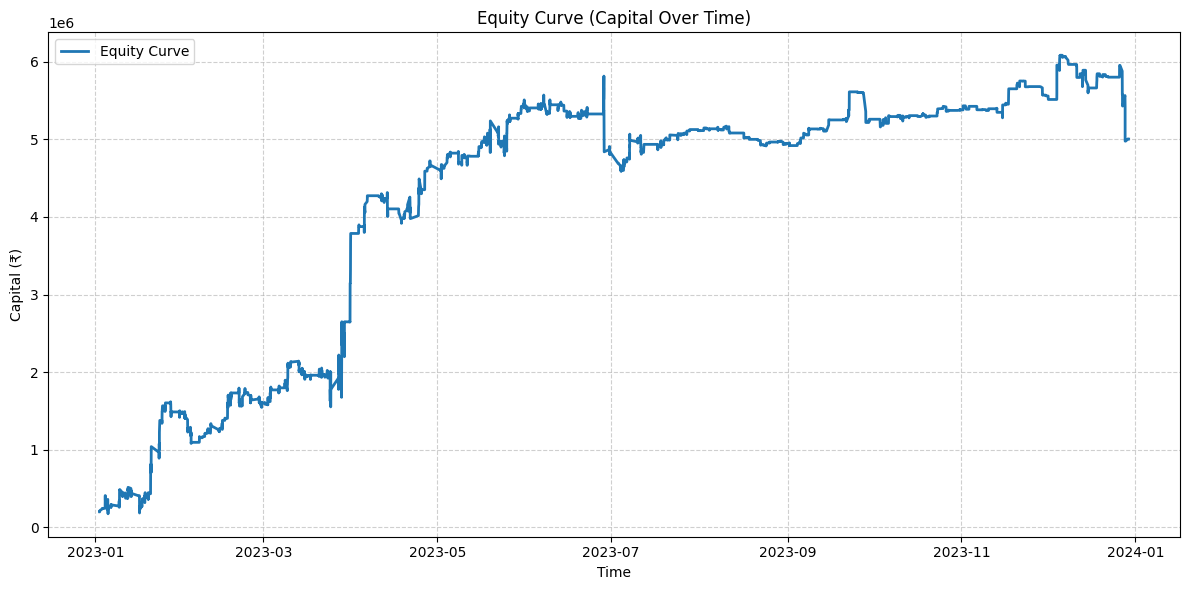

In [4]:
import matplotlib.pyplot as plt

if not trades_df.empty:
    # Ensure datetime type
    trades_df['exit_datetime'] = pd.to_datetime(trades_df['exit_datetime'])
    
    # Create equity curve
    trades_df = trades_df.sort_values('exit_datetime')
    trades_df['equity'] = backtest.starting_capital + trades_df['pnl'].cumsum()
    
    plt.figure(figsize=(12,6))
    plt.plot(trades_df['exit_datetime'], trades_df['equity'], label='Equity Curve', linewidth=2)
    plt.xlabel("Time")
    plt.ylabel("Capital (₹)")
    plt.title("Equity Curve (Capital Over Time)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


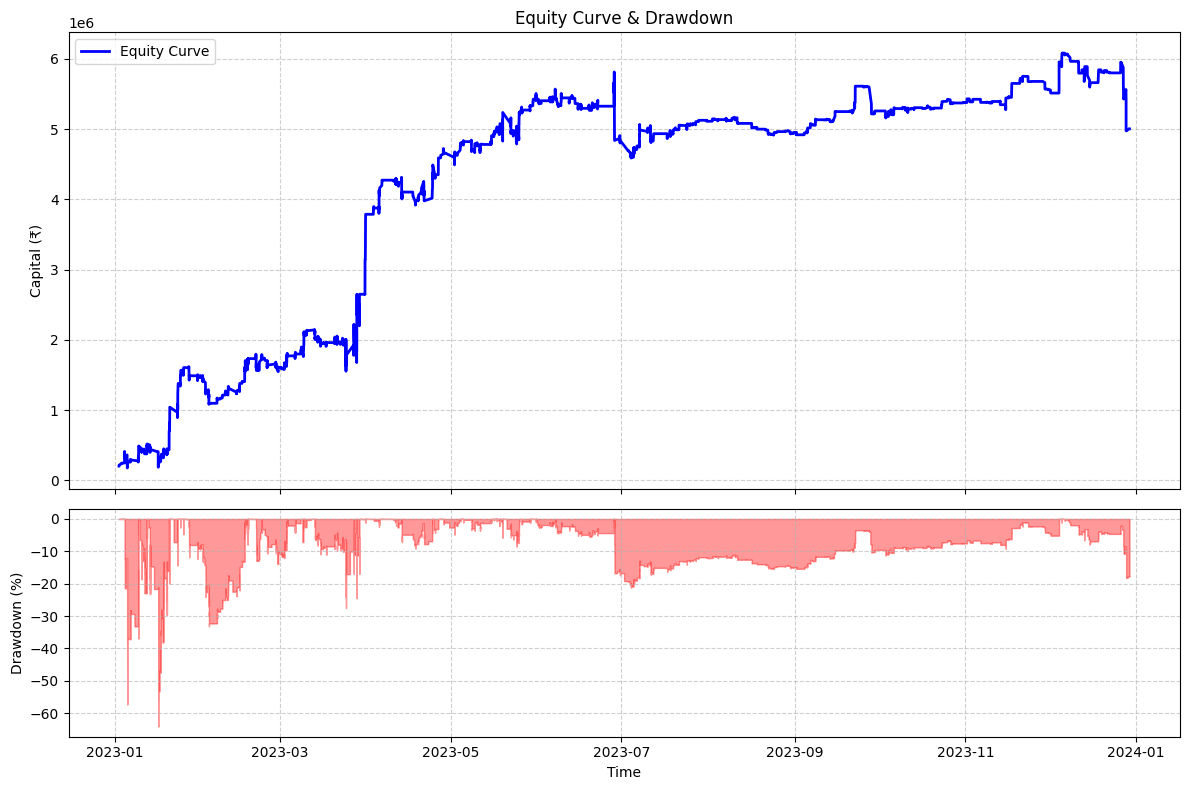

In [5]:
import matplotlib.pyplot as plt

if not trades_df.empty:
    # Ensure datetime type
    trades_df['exit_datetime'] = pd.to_datetime(trades_df['exit_datetime'])
    
    # Sort trades by time
    trades_df = trades_df.sort_values('exit_datetime')
    
    # Equity curve = starting capital + cumulative P&L
    trades_df['equity'] = backtest.starting_capital + trades_df['pnl'].cumsum()
    
    # Running max of equity (for drawdown)
    trades_df['cummax_equity'] = trades_df['equity'].cummax()
    
    # Drawdown = equity - peak equity
    trades_df['drawdown'] = trades_df['equity'] - trades_df['cummax_equity']
    
    # Drawdown % (relative to peak)
    trades_df['drawdown_pct'] = trades_df['drawdown'] / trades_df['cummax_equity'] * 100
    
    # ---- Plot ----
    fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True,
                           gridspec_kw={'height_ratios':[2,1]})
    
    # Equity curve
    ax[0].plot(trades_df['exit_datetime'], trades_df['equity'], label='Equity Curve', linewidth=2, color='blue')
    ax[0].set_ylabel("Capital (₹)")
    ax[0].set_title("Equity Curve & Drawdown")
    ax[0].legend()
    ax[0].grid(True, linestyle="--", alpha=0.6)
    
    # Drawdown (as negative values)
    ax[1].fill_between(trades_df['exit_datetime'], trades_df['drawdown_pct'], 0,
                       color='red', alpha=0.4, step="mid")
    ax[1].set_ylabel("Drawdown (%)")
    ax[1].set_xlabel("Time")
    ax[1].grid(True, linestyle="--", alpha=0.6)
    
    plt.tight_layout()
    plt.show()
